# Install Libraries

In [ ]:
!pip install pymupdf
!wget https://ncert.nic.in/textbook/pdf/lech1dd.zip
!unzip lech1dd.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 39.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 44.2 MB/s eta 0:00:00:00:0100:01


# Function to extract text from PDF using fitz

In [ ]:
import fitz

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    all_text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        all_text += page.get_text()
    doc.close()
    return all_text

# make a dataframe of chapter-wise texts

In [ ]:
import pandas as pd
import os
texts = []
chaps = ['1','2','3','4','5']
for i in os.listdir():
    if i.endswith('.pdf'):
        texts.append(extract_text_from_pdf(i))
chem_text = pd.DataFrame({'text':texts[:5],'chap':chaps})
chem_text

,text,chap
0,"Chemistry, by its very nature, is concerned wi...",1
1,"After studying this Unit, you will be\nable to...",2
2,154\nChemistry\nUNIT 1\n1.4\n16.23 M\n1.5\n0.6...,3
3,Rationalised 2023-24\nFirst Edition\nJanuary 2...,4
4,118\nChemistry\nIn the previous Unit we learnt...,5


# make a dataframe of page number wise texts

In [ ]:
import fitz  # PyMuPDF
import pandas as pd

# Define your PDF file paths
pdf_paths = ['lech101.pdf', 'lech102.pdf', 'lech103.pdf', 'lech104.pdf', 'lech105.pdf']

# Initialize a list to store dictionaries
data = []

# Loop through each PDF file
for chapter, pdf_path in enumerate(pdf_paths, start=1):
    # Open the PDF file
    doc = fitz.open(pdf_path)

    # Loop through each page in the PDF
    for page_num in range(len(doc)):
        # Load the page
        page = doc.load_page(page_num)

        # Extract text from the page
        text = page.get_text()

        # Append the text, page number, and chapter to the data list
        data.append({
            'text': text,
            'page_no': page_num + 1,  # Adding 1 so page numbers start from 1
            'chapter': chapter
        })

    # Close the document
    doc.close()

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()


,text,page_no,chapter
0,"After studying this Unit, you will be\nable to...",1,1
1,2\nChemistry\nType of Solution\nSolute\nSolven...,2,1
2,"3\nSolutions\nFor example, 10% ethanol solutio...",3,1
3,4\nChemistry\nCalculate the mole fraction of e...,4,1
4,5\nSolutions\nExample 1.3\nExample 1.3\nExampl...,5,1


# Tokenize and pad the texts using bert word-piece tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize text
# Tokenize and pad text
def tokenize_and_pad_text(text, max_length):
    # Tokenize the text
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=max_length, truncation=True)
    # Padding the token list to the max_length with the pad_token_id
    padded_tokens = tokens + [tokenizer.pad_token_id] * (max_length - len(tokens))
    return padded_tokens

# First, find the maximum length after tokenization (consider setting a reasonable upper limit)
df['tokenized_text'] = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
max_length = df['tokenized_text'].str.len().max()
print(f"Maximum sequence length: {max_length}")

# Apply tokenization and padding
df['padded_tokenized_text'] = df['text'].apply(lambda x: tokenize_and_pad_text(x, max_length))

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


Maximum sequence length: 858


# Distribution of number of tokens per page

<Axes: >

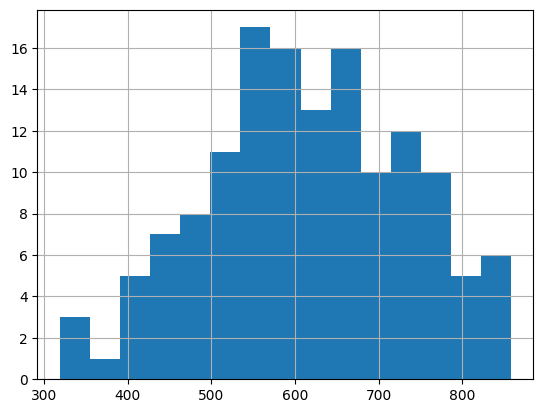

In [ ]:
df['tokenized_text'].apply(lambda x: len(x)).hist(bins = 15)

# Define architecture of autoencoder

In [ ]:
from tensorflow.keras import layers, models

input_length = 858  # Length of your input sequences
embedding_size = 512  # Size of the latent embeddings

# Encoder
encoder_input = layers.Input(shape=(input_length,))
x = layers.Dense(1024, activation='relu')(encoder_input)
x = layers.Dense(768, activation='relu')(x)
latent_view = layers.Dense(embedding_size, activation='relu', name = 'latent_view')(x)

# Decoder
decoder_output = layers.Dense(768, activation='relu')(latent_view)
decoder_output = layers.Dense(1024, activation='relu')(decoder_output)
decoder_output = layers.Dense(input_length, activation='relu')(decoder_output)

# Autoencoder Model
autoencoder = models.Model(encoder_input, decoder_output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 858)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │       879,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 768)            │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_view (Dense)             │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 768)            │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 858)            │       879,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,121,434 (15.72 MB)

 Trainable params: 4,121,434 (15.72 MB)

 Non-trainable params: 0 (0.00 B)

# Define the data to be given to the autoencoder, X = y = tokens

In [ ]:
import numpy as np

X = np.array(df['padded_tokenized_text'].tolist())
y = X

X.shape, y.shape

((140, 858), (140, 858))

# Train the autoencoder

In [ ]:
history = autoencoder.fit(X, y,
                          epochs=100, verbose = 1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 38132456.0000
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 30445274.0000
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 27806764.0000
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 26965610.0000
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 26139822.0000
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 25855488.0000
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 25692750.0000
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 25650576.0000
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 25129366.0000
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 24253584.0000
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 23502078.0000
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 22970212.0000
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 22433978.0000
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2

# Plot the loss (RMSE)

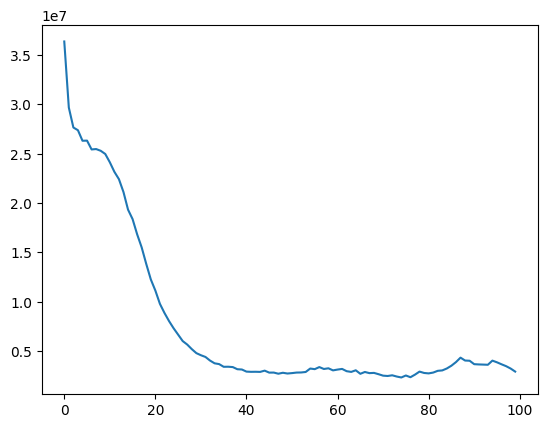

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

# Separate the encoder model from autoencoder to generate latent embeddings

In [ ]:
from tensorflow.keras.models import Model

# Assuming 'latent_view' is the name of the layer where the latent representation is formed
encoder_model = Model(inputs=autoencoder.input,
                      outputs=autoencoder.get_layer('latent_view').output)

# Generate latent embeddings for texts

In [ ]:
latent_embeddings = encoder_model.predict(X)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
latent_embeddings.shape

(140, 512)

In [ ]:
import numpy as np

np.save('latent_embeddings.npy', latent_embeddings)


# Perform PCA and plot the distribution of latent embeddings

In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA to reduce to 2 components
pca = PCA(n_components=2)

# Fit and transform the latent embeddings
latent_embeddings_2d = pca.fit_transform(latent_embeddings)

## -> add eigenvector analysis

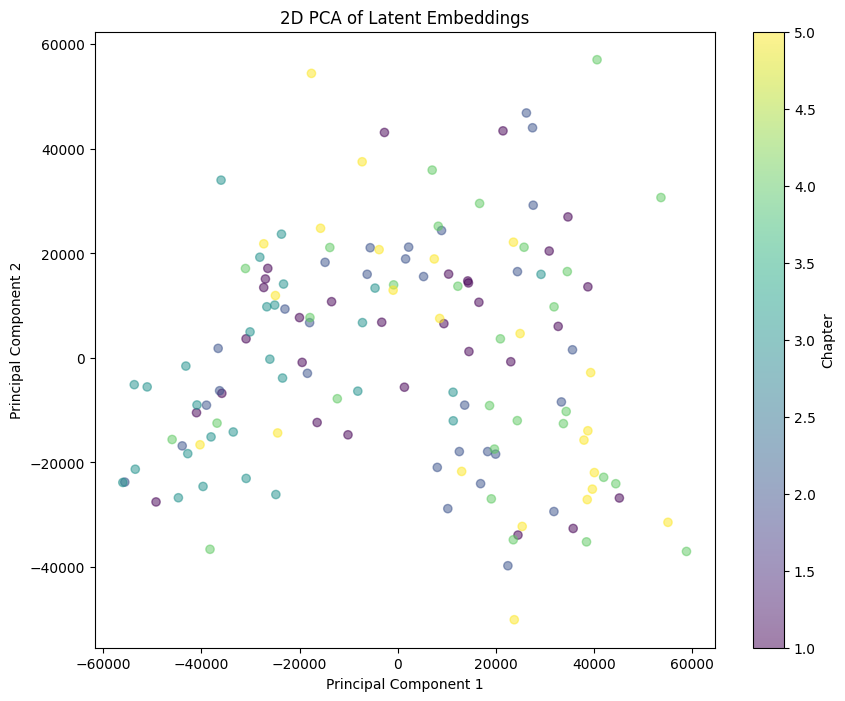

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_embeddings_2d[:, 0], latent_embeddings_2d[:, 1], alpha=0.5, c= df['chapter'])
plt.title('2D PCA of Latent Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Chapter')
plt.show()


# for a given query, generate the latent embedding and search for similar texts in the textbook

In [ ]:
query = "tell me about Henry's Law"
tokenized = np.array(tokenize_and_pad_text(query, 858)).reshape(1,-1)
query_latent = encoder_model.predict(tokenized)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'latent_embeddings' contains all the latent embeddings from your dataset

# Calculate cosine similarity
similarities = cosine_similarity(query_latent, latent_embeddings).flatten()

# Find the indexes of the top k highest similarities
top_k_indexes = np.argsort(similarities)[-5:]

# Assuming you have a DataFrame 'df' with 'page_no' and 'chapter' that corresponds to the embeddings
top_k_pages = df.iloc[top_k_indexes]['page_no'].values
top_k_chapters = df.iloc[top_k_indexes]['chapter'].values


# Page numbers and chapter

In [ ]:
top_k_pages

array([ 8,  7,  6,  9, 10])

In [ ]:
top_k_chapters

array([1, 1, 1, 1, 1])